In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [48]:
sc._settings.ScanpyConfig.n_jobs = 8

In [2]:
def z_score_normalization(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def reorder_columns(df, col_changed, col_position) -> pd.DataFrame:
    """
    Reordering colums. The second input can either be an integer for index or it can be a reference column name. If reference column name is chosen, the column will be placed after the reference column.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The first argument must be a pandas DataFrame")
    if not isinstance(col_changed, str):
        raise ValueError("The second argument must be a string representing a column name")
    if not isinstance(col_position, (str, int)):
        raise ValueError("The third argument must be either a string representing a column name or an integer representing a column index")
    if isinstance(col_position, int):
        cols = df.columns.tolist()
        if col_changed in cols and col_position <= len(cols) + 1:
            cols.remove(col_changed)
        
            index = col_position
            cols.insert(index, col_changed)
            
            df = df[cols]
    else:
        cols = df.columns.tolist()
        if col_changed in cols and col_position in cols:
            cols.remove(col_changed)
            index = cols.index(col_position)
            cols.insert(index+1, col_changed)
            
            df = df[cols]
    return df

In [36]:
df = pd.read_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets2/IMMUcan/quantification/IMMUcan_combined.csv', index_col=0)

In [5]:
df.cell_labels.value_counts()

cell_labels
Tumor         179722
unlabelled    109100
CD8            29612
Mural          29514
MacCD163       21770
CD4            19377
plasma         12071
DC             11750
Neutrophil     10019
BnT             9834
Treg            8284
B               6498
HLADR           5552
pDC             2404
NK              1610
Name: count, dtype: int64

In [37]:
df.columns

Index(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
       'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
       'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
       'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
       'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
       'DNA2', 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area',
       'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px',
       'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description',
       'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI',
       'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI',
       'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes',
       'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos',
       'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels'],
      dtype

In [38]:
df.drop(columns=['acquisition_id', 'Study', 'SlideId', 'Box.Description', 'Position', 'Indication', 'BatchId', 'ROI', 'ROIonSlide', 'includeImage',
                 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'SubBatchId', 'SampleId',
                 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch'], inplace=True) 
df.rename(columns={'celltypes': 'cell_type', 'Pos_X': 'x', 'Pos_Y': 'y'}, inplace=True)

In [39]:
df = reorder_columns(df, 'cell_type', 'cell_labels')

In [40]:
df.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets2/IMMUcan/quantification/processed/IMMUcan_quantification.csv', index=False)

In [41]:
df.columns

Index(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
       'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
       'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
       'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
       'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
       'DNA2', 'image', 'sample_id', 'ObjectNumber', 'x', 'y', 'area',
       'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px',
       'height_px', 'cell_labels', 'cell_type'],
      dtype='object')

In [42]:
X_columns = df.columns[:df.columns.get_loc('image')]
obs_columns =df.columns[df.columns.get_loc('image'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

In [43]:

adata.raw = adata.copy()
adata.X = np.arcsinh(adata.X/1)
adata.layers['zscore'] = z_score_normalization(adata.X)
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')


In [49]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


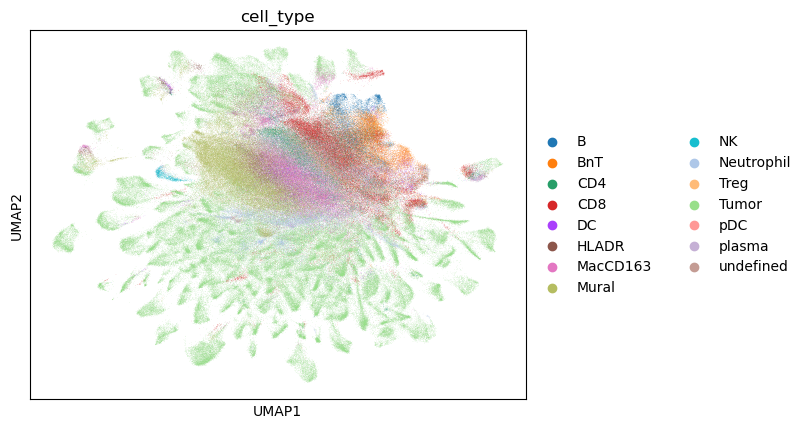

In [50]:
sc.pl.umap(adata, color='cell_type')

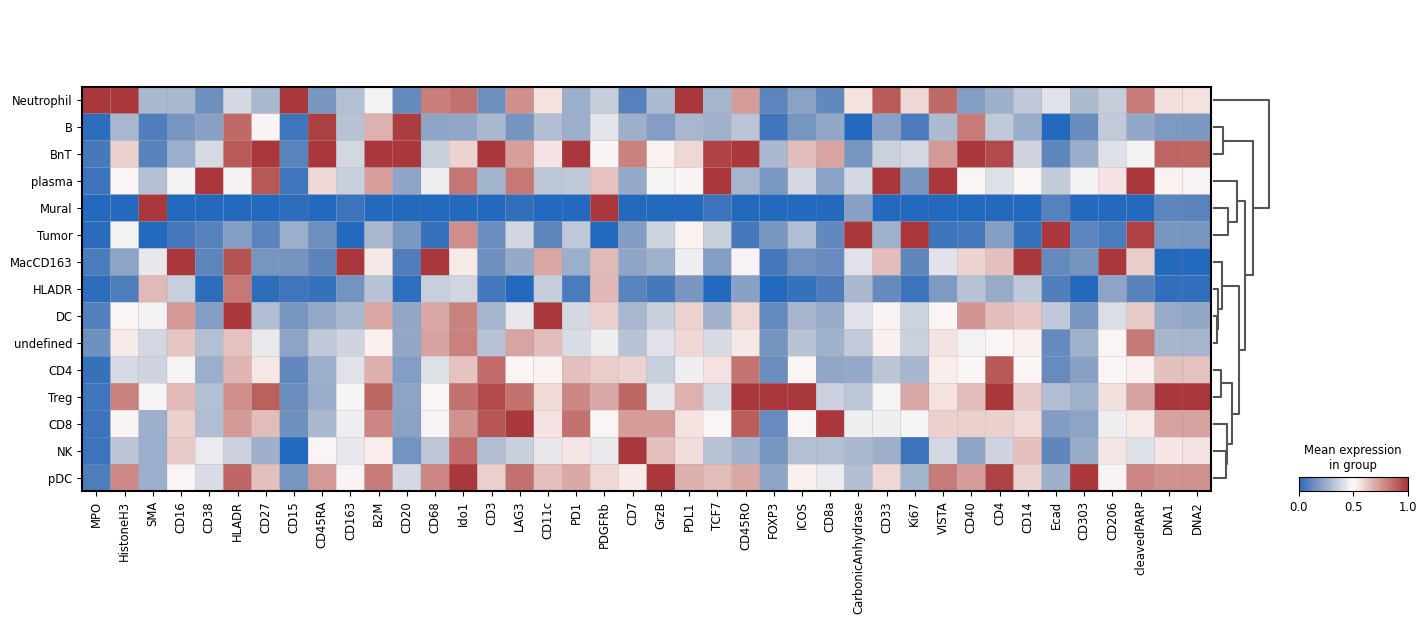

In [46]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, use_raw=False,
                 standard_scale='var'
                 )

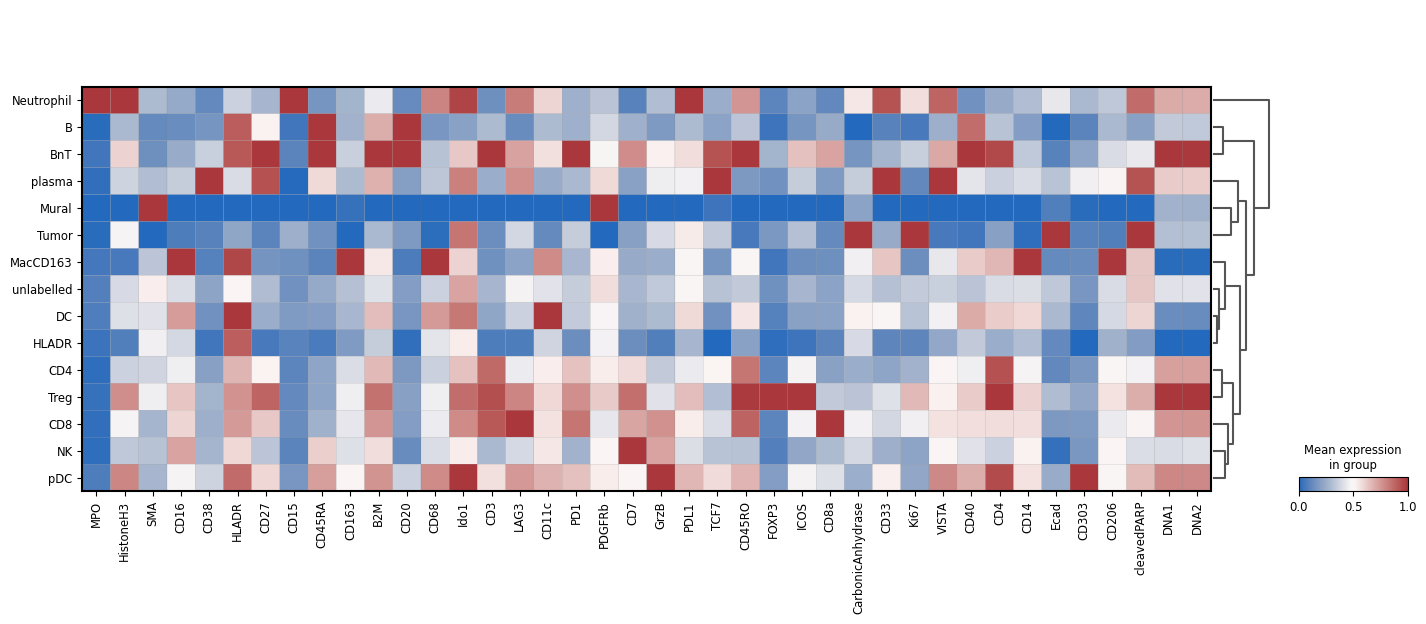

In [51]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_labels', cmap='vlag', dendrogram=True, use_raw=False,
                 standard_scale='var'
                 )